# Federated learning 2-layer MLP on MNIST dataset

reference: https://github.com/AshwinRJ/Federated-Learning-PyTorch

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import copy
from tqdm import notebook
import matplotlib.pyplot as plt

# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# reproducibility
np.random.seed(0)
torch.manual_seed(0)

C:\Software\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Die angegebene Prozedur wurde nicht gefunden
  warn(f"Failed to load image Python extension: {e}")


cuda


## Help functions and classes

In [2]:
# a subset of some dataset that contains selected sample points of it
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, ids):
        """
        @ dataset: raw dataset, in this example it is MNIST train dataset
        @ ids    : a list/tensor/nparray of indices into raw dataset
        """
        self.dataset = dataset
        self.ids = [int(i) for i in ids]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, item):
        image, label = self.dataset[self.ids[item]]
        return torch.tensor(image), torch.tensor(label)

# average parameters
def average_paras(paras, weights = None):
    """
    @ paras  : list of model parameters
    @ weights: number of data points of each client
    """
    if weights == None:
        weights = [1] * len(paras)
        
    paras_avg = copy.deepcopy(paras[0])
    for key in paras_avg.keys():
        paras_avg[key] *= weights[0]
        for i in range(1, len(paras)):
            paras_avg[key] += paras[i][key] * weights[i]
        paras_avg[key] = torch.div(paras_avg[key], sum(weights))
    return paras_avg

# compute weighted average
def weighted_avg(values, weights = None):
    if weights == None:
        weights = [1] * len(values)
    summ = 0
    for weight, value in zip(weights, values):
        summ += weight * value
    return summ / sum(weights)

## Data distribution among clients

In [3]:
# dataset
train_dataset = torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=True)
test_dataset  = torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True, train=False)

# global test data loader
test_loader   = torch.utils.data.DataLoader(test_dataset , batch_size = 64, shuffle = False)

# some prints
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [4]:
# split data among clients
def client_data_split(num_client = 100, iid = True, client_equal_size = True, dataset = train_dataset, num_chunk = 200):
    """ split data among clients
    @ num_client       : number of clients
    @ iid              : whether data is distributed iid.
    @ client_equal_size: whether each client gets same amount of data points
    @ dataset          : MNIST training dataset by default, with 60000 images
    @ num_chunk        : split whole dataset into how many chunks, used to simulate non-iid data distribution
    
    @ return           : list of list of indices into data
    """    
    data_size = len(train_dataset)
    
    if iid and client_equal_size:
        random_ids = np.random.permutation(data_size)
        return np.array_split(random_ids, num_client)
    
    elif iid and not client_equal_size:
        random_ids   = np.random.permutation(data_size)
        split_points = np.random.choice(range(1, data_size-1), num_client - 1, replace = False)
        split_points = np.sort(split_points)
        split_points = np.append(0, split_points)
        split_points = np.append(split_points, data_size)
        return_list  = []
        for i in range(num_client):
            return_list.append(random_ids[split_points[i]:split_points[i+1]])
        return return_list
    
    elif not iid and client_equal_size:
        num_chunk_per_client = num_chunk // num_client
        chunk_size  = data_size // num_chunk
        sort_ids    = np.argsort(train_dataset.targets)
        chunk_ids   = set(range(num_chunk))
        return_list = []
        for i in range(num_client):
            chunk_ids_client = set(np.random.choice(list(chunk_ids), num_chunk_per_client, replace = False))
            chunk_ids = chunk_ids - chunk_ids_client
            elem = np.array([], dtype = 'int32')
            for chunk_id in chunk_ids_client:
                elem = np.concatenate((elem, sort_ids[chunk_id * chunk_size : (chunk_id + 1) * chunk_size]))
            elem = np.random.permutation(elem)
            return_list.append(elem)
        return return_list
    
    else: # iid is False and client_equal_size is False:
        raise Exception("non-iid & non-equal-size not implemented yet!")

## Model

In [5]:
class Vanilla_MLP(torch.nn.Module):
    def __init__(self, input_size = 28*28, layer1_size = 64, num_class = 10, dropout = 0.5):
        super(Vanilla_MLP, self).__init__()
        self.layer0  = torch.nn.Linear(input_size, layer1_size)
        self.layer1  = torch.nn.Linear(layer1_size, num_class)
        self.relu    = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p = dropout)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.layer0(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer1(x)
        return x

## Client

In [6]:
# client is an object, which contains its own dataset, dataloader, local model copy (for simplification, only local parameters) and training loop fucntion
class Client(object):
    def __init__(self, data_ids, client_id, model = Vanilla_MLP(), train_dataset = train_dataset, train_test_split = 0, batch_size = 64, num_epoch = 10, optimizer = torch.optim.Adam, learning_rate = 1e-4, l2_regular = 0.1, loss_func = F.cross_entropy, print_round = 1):
        """
        @ data_ids        : indices into raw train dataset
        @ client_id       : id of this client
        @ model           : model of this client
        @ train_dataset   : raw train dataset, by default MNIST train dataset
        @ train_test_split: 0.8 by default
        @ batch_size      : local batch size , by default 64
        @ num_epoch       : number of local training epochs between two global updates, by default 10
        @ optimizer       : Adam by default
        @ learning_rate   : 1e-4 by default
        @ l2_regular      : 0.1 by default
        @ loss_func       : cross entropy by default
        @ print_round     : print frequency, 1 by default
        """
        self.model         = model
        self.client_id     = client_id
        self.num_epoch     = num_epoch
        self.loss_func     = loss_func
        self.print_round   = print_round
        self.data_ids      = data_ids
        self.optimizer     = optimizer(model.parameters(), lr = learning_rate, weight_decay = l2_regular)
        
        # local train-test-split, any value of train_test_split <= 0 or >= 1 is considered as not doing split, hence no local test
        self.local_split = 0 < train_test_split < 1
        if self.local_split:
            train_test_split   = max(train_test_split, 1-train_test_split)
            split_point        = int(train_test_split * len(data_ids))
            self.train_ids     = data_ids[:split_point]
            self.test_ids      = data_ids[split_point:]
            self.train_dataset = DatasetSplit(train_dataset, self.train_ids)
            self.test_dataset  = DatasetSplit(train_dataset, self.test_ids)
            self.train_loader  = torch.utils.data.DataLoader(self.train_dataset, batch_size = batch_size, shuffle=True)
            self.test_loader   = torch.utils.data.DataLoader(self.test_dataset , batch_size = batch_size, shuffle=False)
        else:
            self.train_ids     = self.data_ids
            self.train_dataset = DatasetSplit(train_dataset, self.train_ids)
            self.train_loader  = torch.utils.data.DataLoader(self.train_dataset, batch_size = batch_size, shuffle=True)
            
        self.train_losses       = []
        self.test_losses_before = []
        self.test_accus_before  = []
        self.test_losses_after  = []
        self.test_accus_after   = []
    
    ############################### local train ###################################
    def local_train(self, global_round = -1):
        """ local training
        
        @ global_round: current global update round, only used for print
        
        @ return      : updated model and avg training loss per epoch
        """
        self.model.to(device)
        self.model.train()
        epoch_losses = []
        
        for epoch in range(self.num_epoch):
            sum_batch_loss = 0
            
            for batch_id, (images, labels) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                
                images = images.to(device)
                labels = labels.to(device)
                
                predicts = self.model(images)
                
                loss = self.loss_func(predicts, labels, reduction = 'sum')
                loss.backward()
                self.optimizer.step()
                
                sum_batch_loss += loss.item()
            
            epoch_loss = sum_batch_loss / len(self.train_ids)
            epoch_losses.append(epoch_loss)
        
        self.train_losses.append(epoch_losses)
        avg_epoch_loss = sum(epoch_losses) / self.num_epoch
        
        if global_round % self.print_round == 0:
            print("global round: {:02d}".format(global_round), " client: {:02d}".format(self.client_id), " local train loss: {:.4f}".format(avg_epoch_loss))
        
        self.model.to('cpu')
        
        return self.model, avg_epoch_loss
    
    ############################### local test ###################################
    def local_test(self, global_round = -1, before_agg = True):
        """ local test
        
        @ global_round: current global update round, only used for print
        @ before_agg  : whether test happens before or after global aggregation
        
        @ return      : avg test loss and avg test accuracy
        """
        # only run local test if local train-test-split is done
        assert(self.local_split)
        
        self.model.to(device)
        self.model.eval()
        sum_batch_loss = 0
        num_correct_preds = 0
            
        for batch_id, (images, labels) in enumerate(self.test_loader):
            images = images.to(device)
            labels = labels.to(device)

            predicts = self.model(images)

            loss = self.loss_func(predicts, labels, reduction = 'sum')
            sum_batch_loss += loss.item()
            
            _, pred_labels = torch.max(predicts, 1)
            pred_labels = pred_labels.view(-1)
            num_correct_preds += torch.sum(torch.eq(pred_labels, labels)).item()

        avg_loss = sum_batch_loss / len(self.test_ids)
        avg_accu = num_correct_preds / len(self.test_ids)
        if before_agg:
            self.test_losses_before.append(avg_loss)
            self.test_accus_before .append(avg_accu)
        else:
            self.test_losses_after .append(avg_loss)
            self.test_accus_after  .append(avg_accu)
        
        if global_round % self.print_round == 0:
            print("global round: {:02d}".format(global_round), " client: {:02d}".format(self.client_id), " local test  loss: {:.4f}".format(avg_loss), " local test accu: {:.3f}".format(avg_accu), " before agg:", before_agg)
            
        self.model.to('cpu')
        
        return avg_loss, avg_accu

## Global update

In [7]:
# main function
def federated_learning( num_global_round       = 100 ,
                        num_client             = 100 ,
                        same_init              = True,       # whether all local models have the same starting point 
                        update_C               = 0.1 ,       # proportion of clients updated per round, which is the parameter C in paper, range 0.0 ~ 1.0 
                        iid                    = True,
                        client_equal_size      = True,
                        print_round            = 1   ,
                        local_train_test_split = 0   ,         # any value outside of <=0 or >=1.0 is considers as not doing train-test-split locally, hence local test is also not possible
                        local_batch_size       = 64  ,
                        local_num_epoch        = 10  ,
                        local_learning_rate    = 1e-4,
                        local_l2_regular       = 0.1 ,
                        ):
    """ main function for federated learning global update
    
    @ num_global_round      : number of global update rounds
    @ num_client            : number of clients
    @ same_init             : whether all client models have the same initialization
    @ update_C              : proportion of clients updated per round, which is the parameter C in paper, range 0.0 ~ 1.0
    @ iid                   : whether data distribution among clients is iid
    @ client_equal_size     : whether each client has same amount of data
    @ print_round           : print something per round
    @ local_train_test_split: whether each client does train-test-split locally, any value <= 0 or >= means not doing the split, and hence no local test/validation
    @ local_batch_size      : batch size for local training, which is the parameter B in paper
    @ local_num_epoch       : number of epochs each client go through between two global update rounds, which is the parameter E in paper, can be an int or a list of int
    @ local_learning_rate   : learnng rate for local training
    @ local_l2_regular      : weight decay for local training
    
    @ return                : loss/accu history and clients
    """
    # split data among clients
    data_splits     = client_data_split(num_client = num_client, iid = iid, client_equal_size = client_equal_size)
    num_client_data = [len(i) for i in data_splits]

    # global model
    global_model = Vanilla_MLP()

    # generate client instances
    clients = []
    local_num_epoch = [local_num_epoch] * num_client if isinstance(local_num_epoch, int) else local_num_epoch # int to list 
    for i in range(num_client):
        if same_init:
            client = Client(model = copy.deepcopy(global_model), batch_size = local_batch_size, num_epoch = local_num_epoch[i], learning_rate = local_learning_rate, 
                            l2_regular = local_l2_regular, print_round = print_round, data_ids = data_splits[i], train_test_split = local_train_test_split, client_id = i)
        else:
            client = Client(model = Vanilla_MLP(), batch_size = local_batch_size, num_epoch = local_num_epoch[i], learning_rate = local_learning_rate, 
                            l2_regular = local_l2_regular, print_round = print_round, data_ids = data_splits[i], train_test_split = local_train_test_split, client_id = i)
        clients.append(client)

    # number of clients to update per round
    num_update_client   = min(max(int(update_C * num_client), 1), num_client)

    # global update loop
    local_split = 0 < local_train_test_split < 1
    local_train_losses       = []
    local_test_losses_before = []
    local_test_accus_before  = []
    local_test_losses_after  = []
    local_test_accus_after   = []
    global_test_losses       = []
    global_test_accus        = []
    for global_round in notebook.tqdm(range(num_global_round)):
        client_ids         = np.random.choice(num_client, num_update_client, replace=False)
        client_weights     = [num_client_data[client_id] for client_id in client_ids]
        new_paras          = []
        train_losses       = []
        test_losses_before = []
        test_accus_before  = []
        test_losses_after  = []
        test_accus_after   = []

        # local train
        for client_id in client_ids:
            client = clients[client_id]

            # local train
            new_model, train_loss = client.local_train(global_round = global_round)
            new_paras   .append(new_model.state_dict())
            train_losses.append(train_loss)

            # local test before global aggregation
            if local_split:
                test_loss, test_accu = client.local_test (global_round = global_round, before_agg = True)
                test_losses_before.append(test_loss)
                test_accus_before .append(test_accu)

        # global aggregation
        new_paras.append(global_model.state_dict())
        client_weights.append(len(train_dataset))
        new_global_paras = average_paras(weights = client_weights, paras = new_paras)

        # update global model
        global_model.load_state_dict(new_global_paras)

        # update local models
        for client_id in client_ids:
            clients[client_id].model.load_state_dict(new_global_paras)

        # local test after global aggregation
        if local_split:
            print()
            for client_id in client_ids:
                client = clients[client_id]

                test_loss, test_accu = client.local_test (global_round = global_round, before_agg = False)
                test_losses_after.append(test_loss)
                test_accus_after .append(test_accu)

        # average local loss and accuracy
        avg_train_loss = weighted_avg(weights = client_weights, values = train_losses) ; local_train_losses.append(avg_train_loss)
        if local_split:    
            avg_test_loss_before = weighted_avg(weights = client_weights, values = test_losses_before) ; local_test_losses_before.append(avg_test_loss_before)
            avg_test_accu_before = weighted_avg(weights = client_weights, values = test_accus_before)  ; local_test_accus_before .append(avg_test_accu_before)
            avg_test_loss_after  = weighted_avg(weights = client_weights, values = test_losses_after)  ; local_test_losses_after .append(avg_test_loss_after)
            avg_test_accu_after  = weighted_avg(weights = client_weights, values = test_accus_after)   ; local_test_accus_after  .append(avg_test_accu_after)

        # global test
        global_model.to(device)
        global_model.eval()
        sum_batch_loss = 0
        num_correct_preds = 0
        for batch_id, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            predicts = global_model(images)

            loss = F.cross_entropy(predicts, labels, reduction = 'sum')
            sum_batch_loss += loss.item()

            _, pred_labels = torch.max(predicts, 1)
            pred_labels = pred_labels.view(-1)
            num_correct_preds += torch.sum(torch.eq(pred_labels, labels)).item()

        avg_loss = sum_batch_loss / len(test_dataset)
        global_test_losses.append(avg_loss)

        avg_accu = num_correct_preds / len(test_dataset)
        global_test_accus .append(avg_accu)

        global_model.to('cpu')

        # print per round
        if global_round % print_round == 0:
            print("global round: {:02d}".format(global_round),  " avg train loss:{:.4f}".format(avg_train_loss), " global test loss: {:.4f}".format(avg_loss), " global test accu: {:.4f}".format(avg_accu))
            if local_split:
                print("    avg test loss before: {:.4f}".format(avg_test_loss_before), " avg test accu before: {:.3f}".format(avg_test_accu_before), " avg test loss after : {:.4f}".format(avg_test_loss_after), " avg test accu after : {:.3f}".format(avg_test_accu_after),)
            print("================================================================================================================")
            
    # return 
    histories = {}
    histories["local_train_losses"] = local_train_losses
    histories["global_test_losses"] = global_test_losses
    histories["global_test_accus"]  = global_test_accus
    if local_split:
        histories["avg_test_loss_before"] = avg_test_loss_before
        histories["avg_test_accu_before"] = avg_test_accu_before
        histories["avg_test_loss_after"]  = avg_test_loss_after
        histories["avg_test_accu_after"]  = avg_test_accu_after
    return histories, clients

## Plots

In [10]:
# iid, client_equal_size
histories, client = federated_learning(iid = True,
                                       same_init = True,
                                       client_equal_size = True,
                                       num_global_round = 200)

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\ga92nam\AppData\Local\Temp\ipykernel_17828\4185283577.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


global round: 00  client: 18  local train loss: 2.1466
global round: 00  client: 19  local train loss: 2.1441
global round: 00  client: 06  local train loss: 2.1478
global round: 00  client: 88  local train loss: 2.1685
global round: 00  client: 68  local train loss: 2.1319
global round: 00  client: 36  local train loss: 2.1378
global round: 00  client: 52  local train loss: 2.1586
global round: 00  client: 27  local train loss: 2.1315
global round: 00  client: 15  local train loss: 2.1619
global round: 00  client: 91  local train loss: 2.1434
global round: 00  avg train loss:0.1952  global test loss: 2.2709  global test accu: 0.1295
global round: 01  client: 38  local train loss: 2.1581
global round: 01  client: 30  local train loss: 2.1420
global round: 01  client: 21  local train loss: 2.1542
global round: 01  client: 17  local train loss: 2.1657
global round: 01  client: 18  local train loss: 2.1137
global round: 01  client: 75  local train loss: 2.1636
global round: 01  client: 03

### iid, client_equal_size

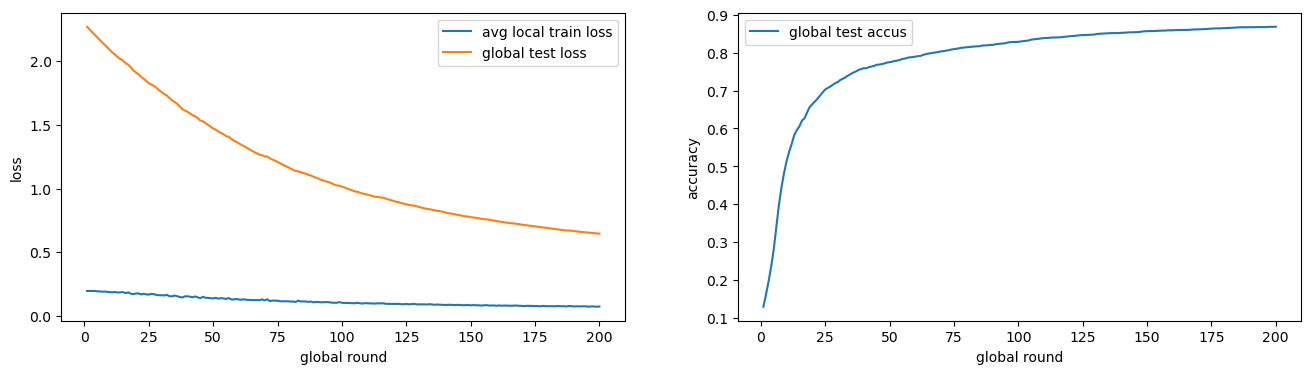

In [11]:
plt.figure(figsize = (16, 4)) 

num_global_round = len(histories["local_train_losses"])
plt.subplot(1, 2, 1)
plt.plot(range(1, num_global_round + 1), histories["local_train_losses"], label = 'avg local train loss')
plt.plot(range(1, num_global_round + 1), histories["global_test_losses"], label = 'global test loss')
plt.xlabel('global round')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_global_round + 1), histories["global_test_accus"], label = 'global test accus')
plt.xlabel('global round')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [12]:
# non-iid, client_equal_size
histories, client = federated_learning(iid = False,
                                       same_init = True,
                                       client_equal_size = True,
                                       num_global_round = 200)

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\ga92nam\AppData\Local\Temp\ipykernel_17828\4185283577.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


global round: 00  client: 82  local train loss: 1.6480
global round: 00  client: 51  local train loss: 1.5542
global round: 00  client: 43  local train loss: 1.6832
global round: 00  client: 39  local train loss: 1.8798
global round: 00  client: 57  local train loss: 1.4933
global round: 00  client: 91  local train loss: 1.4215
global round: 00  client: 76  local train loss: 1.6412
global round: 00  client: 09  local train loss: 1.6057
global round: 00  client: 69  local train loss: 1.9087
global round: 00  client: 46  local train loss: 1.4378
global round: 00  avg train loss:0.1479  global test loss: 2.3160  global test accu: 0.0669
global round: 01  client: 19  local train loss: 1.5842
global round: 01  client: 34  local train loss: 1.4058
global round: 01  client: 85  local train loss: 1.7436
global round: 01  client: 53  local train loss: 1.5801
global round: 01  client: 58  local train loss: 1.2160
global round: 01  client: 73  local train loss: 1.6427
global round: 01  client: 83

### non-iid, client_equal_size

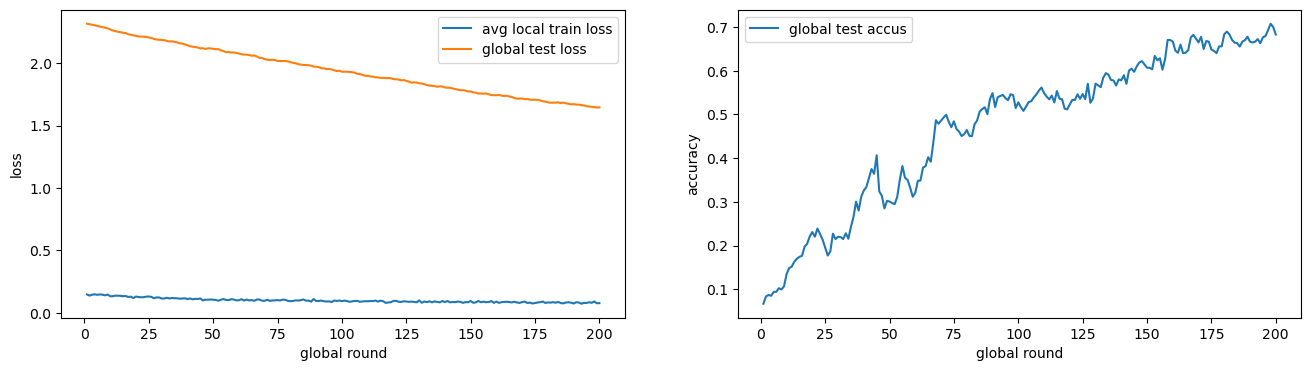

In [13]:
plt.figure(figsize = (16, 4)) 

num_global_round = len(histories["local_train_losses"])
plt.subplot(1, 2, 1)
plt.plot(range(1, num_global_round + 1), histories["local_train_losses"], label = 'avg local train loss')
plt.plot(range(1, num_global_round + 1), histories["global_test_losses"], label = 'global test loss')
plt.xlabel('global round')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_global_round + 1), histories["global_test_accus"], label = 'global test accus')
plt.xlabel('global round')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [14]:
# iid, not client_equal_size
histories, client = federated_learning(iid = True,
                                       same_init = True,
                                       client_equal_size = False,
                                       num_global_round = 200)

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\ga92nam\AppData\Local\Temp\ipykernel_17828\4185283577.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


global round: 00  client: 49  local train loss: 2.2575
global round: 00  client: 84  local train loss: 2.0695
global round: 00  client: 64  local train loss: 2.1100
global round: 00  client: 88  local train loss: 1.7218
global round: 00  client: 61  local train loss: 2.2183
global round: 00  client: 05  local train loss: 2.2614
global round: 00  client: 82  local train loss: 2.1281
global round: 00  client: 08  local train loss: 2.2651
global round: 00  client: 25  local train loss: 2.2155
global round: 00  client: 79  local train loss: 2.2172
global round: 00  avg train loss:0.1956  global test loss: 2.2459  global test accu: 0.2341
global round: 01  client: 69  local train loss: 2.2429
global round: 01  client: 83  local train loss: 2.1815
global round: 01  client: 88  local train loss: 1.6631
global round: 01  client: 11  local train loss: 2.2370
global round: 01  client: 87  local train loss: 1.7405
global round: 01  client: 16  local train loss: 2.2332
global round: 01  client: 36

### iid, not client_equal_size

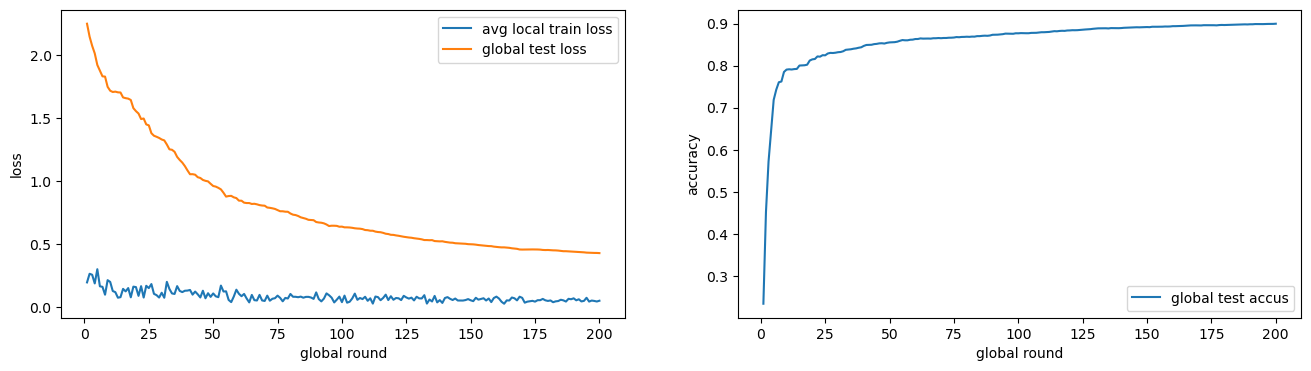

In [15]:
plt.figure(figsize = (16, 4)) 

num_global_round = len(histories["local_train_losses"])
plt.subplot(1, 2, 1)
plt.plot(range(1, num_global_round + 1), histories["local_train_losses"], label = 'avg local train loss')
plt.plot(range(1, num_global_round + 1), histories["global_test_losses"], label = 'global test loss')
plt.xlabel('global round')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_global_round + 1), histories["global_test_accus"], label = 'global test accus')
plt.xlabel('global round')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [16]:
# different init point
histories, client = federated_learning(iid = True,
                                       same_init = False,
                                       client_equal_size = True,
                                       num_global_round = 200)

  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\ga92nam\AppData\Local\Temp\ipykernel_17828\4185283577.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


global round: 00  client: 40  local train loss: 2.1681
global round: 00  client: 11  local train loss: 2.1828
global round: 00  client: 58  local train loss: 2.1580
global round: 00  client: 38  local train loss: 2.1582
global round: 00  client: 96  local train loss: 2.1906
global round: 00  client: 79  local train loss: 2.1684
global round: 00  client: 36  local train loss: 2.1830
global round: 00  client: 80  local train loss: 2.1697
global round: 00  client: 92  local train loss: 2.1608
global round: 00  client: 76  local train loss: 2.1458
global round: 00  avg train loss:0.1971  global test loss: 2.3142  global test accu: 0.0882
global round: 01  client: 86  local train loss: 2.1578
global round: 01  client: 75  local train loss: 2.1865
global round: 01  client: 39  local train loss: 2.1544
global round: 01  client: 23  local train loss: 2.1658
global round: 01  client: 30  local train loss: 2.1814
global round: 01  client: 92  local train loss: 2.1830
global round: 01  client: 79

### different init point

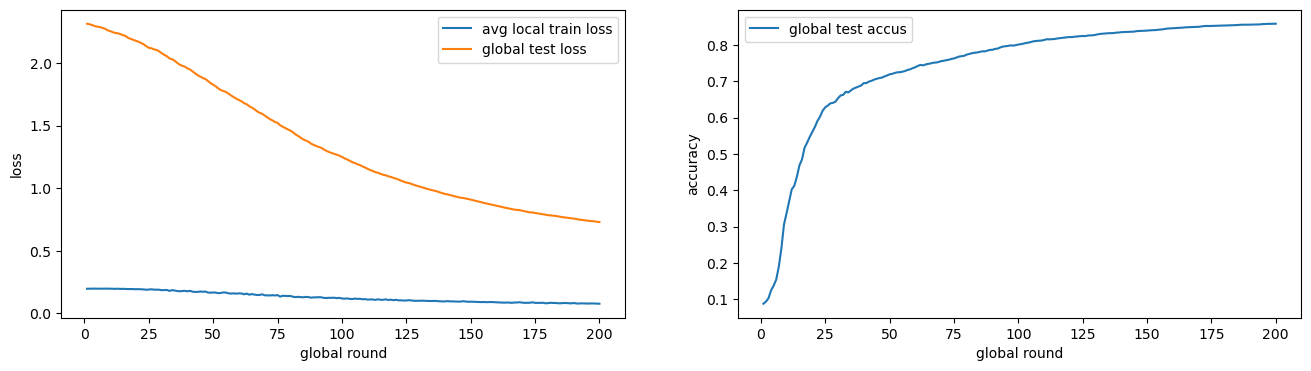

In [17]:
plt.figure(figsize = (16, 4)) 

num_global_round = len(histories["local_train_losses"])
plt.subplot(1, 2, 1)
plt.plot(range(1, num_global_round + 1), histories["local_train_losses"], label = 'avg local train loss')
plt.plot(range(1, num_global_round + 1), histories["global_test_losses"], label = 'global test loss')
plt.xlabel('global round')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_global_round + 1), histories["global_test_accus"], label = 'global test accus')
plt.xlabel('global round')
plt.ylabel('accuracy')
plt.legend()

plt.show()